In [1]:
from pds_functions import *
from kde_functions import *
from DTM_filtrations import *
import matplotlib.pyplot as plt

In [2]:
def generate_circle(radius=1, num_points=500, noise_std=0.05, shifts=0):
    angles = np.linspace(0, 2*np.pi, num_points)
    x = radius * np.cos(angles) + shifts
    y = radius * np.sin(angles) + shifts
    # Add Gaussian noise to the coordinates
    noise_x = np.random.normal(scale=noise_std, size=num_points)
    noise_y = np.random.normal(scale=noise_std, size=num_points)
    x += noise_x
    y += noise_y
    return np.column_stack((x, y))

def add_noise(X, num_points=500):
    min_x, min_y = np.min(X, axis=0)
    max_x, max_y = np.max(X, axis=0)
    # Generate random points within the determined bounds
    random_x = np.random.uniform(min_x, max_x, num_points)
    random_y = np.random.uniform(min_y, max_y, num_points)
    # Combine the random points into an array
    random_points = np.column_stack((random_x, random_y))
        # Combine the true manifold with the random points
    noisy_X = np.vstack((X, random_points))
    return noisy_X

In [3]:
# Generate the two data spaces
np.random.seed(100)
n_samples = 500
true_manifold_sparse = np.asarray(generate_circle(1, 50, 0.05))
true_manifold_dense = np.asarray(generate_circle(.5, n_samples, 0.05, .0))
true_manifold = np.vstack((true_manifold_dense, true_manifold_sparse))
noisy_manifold = add_noise(true_manifold, 450)

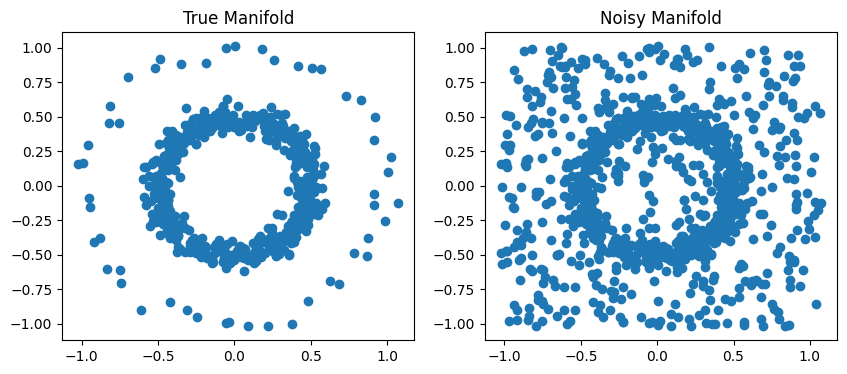

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].scatter(x=true_manifold[:, 0], y=true_manifold[:, 1])
axs[0].set_title('True Manifold')
axs[1].scatter(x=noisy_manifold[:, 0], y=noisy_manifold[:, 1])
axs[1].set_title('Noisy Manifold')
plt.show()

In [5]:
# KDE samples with no thresholding
kde_fit_nothresh, props_nothresh_, bounding_box_ = kde_fit(noisy_manifold, k=1, eps=0)
kde_samples_nothresh, _= kde_sample(kde=kde_fit_nothresh, proposals=props_nothresh_, bounding_box=bounding_box_, num_samples=n_samples) 
# KDE samples with thresholding
kde_fit_thresh, props_thresh_, bounding_box_ = kde_fit(noisy_manifold, k=1, eps=-.5)
kde_samples_thresh, _= kde_sample(kde=kde_fit_thresh, proposals=props_thresh_, bounding_box=bounding_box_, num_samples=n_samples) 

In [6]:
pd.DataFrame(true_manifold).to_csv('../data/tprecovery/annulus_tm.csv')
pd.DataFrame(noisy_manifold).to_csv('../data/tprecovery/annulus_nm.csv')
pd.DataFrame(kde_samples_thresh).to_csv('../data/tprecovery/annulus_kde_th.csv')
pd.DataFrame(kde_samples_nothresh).to_csv('../data/tprecovery/annulus_kde_nt.csv')

In [ ]:
# Compute and plot the DTM persistence diagrams
m = 0.05
diagram_DTM, _, _ = dtm_diagram(noisy_manifold, m)
diagram_DTM_thresh, _, _ = dtm_diagram(kde_samples_thresh, m)
diagram_DTM_nothresh, _, _ = dtm_diagram(kde_samples_nothresh, m)

def max_pers(diagram):
    filtered_items = [item for item in diagram if item[0] == 1]
    differences = [pair[1][1] - pair[1][0] for pair in filtered_items]
    max_pers = max(differences)
    return max_pers

max_pers_original = max_pers(diagram_DTM)
max_pers_nothresh = max_pers(diagram_DTM_nothresh)
max_pers_thresh = max_pers(diagram_DTM_thresh)

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
gudhi.plot_persistence_diagram(diagram_DTM, axes=axes[0])
axes[0].set_title(f'DTM NM MP = {np.round(max_pers_original, 2)}')
gudhi.plot_persistence_diagram(diagram_DTM_nothresh, axes=axes[1])
axes[1].set_title(f'DTM NT  MP = {np.round(max_pers_nothresh, 2)}')
gudhi.plot_persistence_diagram(diagram_DTM_thresh, axes=axes[2])
axes[2].set_title(f'DTM TH MP = {np.round(max_pers_thresh, 2)}')
plt.show()

In [7]:
# Repeat the thresholdig sampling for error bars
for k in range(100):
    true_manifold_sparse = np.asarray(generate_circle(1, 50, 0.05))
    true_manifold_dense = np.asarray(generate_circle(.5, n_samples, 0.05, .0))
    true_manifold = np.vstack((true_manifold_dense, true_manifold_sparse))
    pd.DataFrame(true_manifold).to_csv(f'../data/tprecovery/annulus_tm{k}.csv')
    noisy_manifold = add_noise(true_manifold, 450)
    pd.DataFrame(noisy_manifold).to_csv(f'../data/tprecovery/annulus_nm{k}.csv')
    # KDE samples with no thresholding
    kde_fit_nothresh, props_nothresh_, bounding_box_ = kde_fit(noisy_manifold, k=1, eps=0)
    kde_samples_nothresh, _= kde_sample(kde=kde_fit_nothresh, proposals=props_nothresh_, bounding_box=bounding_box_, num_samples=n_samples) 
    pd.DataFrame(kde_samples_nothresh).to_csv(f'../data/tprecovery/annulus_kde_nt{k}.csv')
    # KDE samples with thresholding
    kde_fit_thresh, props_thresh_, bounding_box_ = kde_fit(noisy_manifold, k=1, eps=-.5)
    kde_samples_thresh, _= kde_sample(kde=kde_fit_thresh, proposals=props_thresh_, bounding_box=bounding_box_, num_samples=n_samples)
    pd.DataFrame(kde_samples_thresh).to_csv(f'../data/tprecovery/annulus_kde_th{k}.csv')